In [1]:
import sys
sys.path.insert(0, '..')
# Allows plots to be zoomed in, etc
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import time

from Configuration import Configuration
from InterneuronPoolOpt import InterneuronPool
from SynapsesFactory import SynapsesFactory

In [53]:
def simulator(numberRC, duration, current, newParametrization):

    conf = Configuration('confuchiyama.rmto')

    # Number of cells
    idx = np.where(conf.confArray['f0']=='Number_RC_ext')[0][0]
    conf.confArray['f1'][idx] = numberRC
    
    # Duration of simulation
    conf.simDuration_ms = duration
    
    # Parameters from java
    idx = np.where(conf.confArray['f0']=='gmax_Ks:RC_ext-@soma')[0][0]
    conf.confArray['f1'][idx] = 13869.242289183921
    idx = np.where(conf.confArray['f0']=='gmax_Kf:RC_ext-@soma')[0][0]
    conf.confArray['f1'][idx] = 84819.65682525466

    ## Threshold (makes a rheobase of 0.5 nA)
    idx = np.where(conf.confArray['f0']=='threshold:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 0.1724138
    conf.confArray['f2'][idx] = 0.1724138

    ## Morphology
    idx = np.where(conf.confArray['f0']=='d@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 64.77885
    conf.confArray['f2'][idx] = 64.77885
    idx = np.where(conf.confArray['f0']=='l@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 285
    conf.confArray['f2'][idx] = 285
    idx = np.where(conf.confArray['f0']=='res@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 8000
    conf.confArray['f2'][idx] = 8000
    
    pools = dict()
    pools[0] = InterneuronPool(conf, 'RC', 'ext')

    Syn = SynapsesFactory(conf, pools)

    t = np.arange(0.0, conf.simDuration_ms, conf.timeStep_ms)

    RC_mV = np.zeros_like(t)
    for i in xrange(0, len(t)):
        if t[i]>10 and t[i]<20:
            for j in xrange(len(pools[0].unit)):
                pools[0].iInjected[j] = current
        else:
            for j in xrange(len(pools[0].unit)):
                pools[0].iInjected[j] = 0
        #pools[1].atualizePool(t[i]) # RC synaptic Noise
        pools[0].atualizeInterneuronPool(t[i]) # RC pool
        RC_mV[i] = pools[0].unit[0].v_mV[0]

    pools[0].listSpikes()

    return RC_mV, t

In [57]:
nRC = 1
t = 100
newParams = False
i = 0.5
#i = 0.1 # for time constant

RCMembrane, t = simulator(nRC, t, i, newParams)

Interneuron Pool of RC ext built
All the 0 synapses were built
Synaptic Noise on RC_ext built
All the 1 synaptic noises were built


In [58]:
# Calculate AHP duration
i = 0
f = 0
for j in xrange(len(RCMembrane)):
    if RCMembrane[j] < 0:
        i = j
        break
for j in xrange(i, len(RCMembrane)):
    if np.isclose(RCMembrane[j], 0.0, atol=0.1):
        f = j
        break
AHPa = min(RCMembrane)
AHPt = t[f]-t[i]
print "AHP amplitude is " + str(AHPa)
print "AMP duration is " + str(AHPt)

AHP amplitude is -5.830377902955002
AMP duration is -10.5


<IPython.core.display.Javascript object>


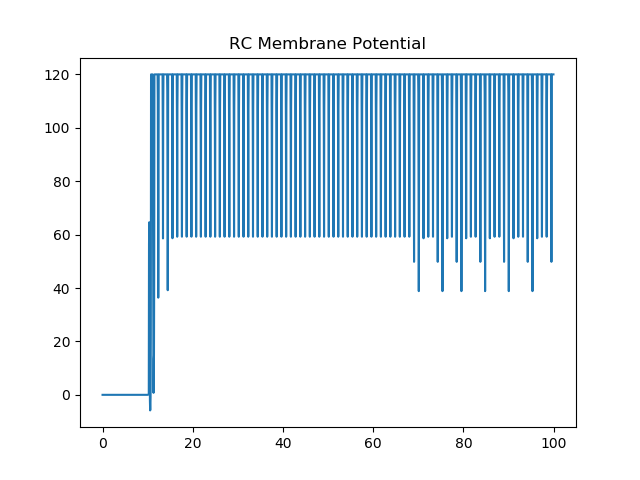

In [60]:
plt.figure()
plt.plot(t, RCMembrane)
plt.title('RC Membrane Potential')
plt.show()